In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16, 
  'grid.alpha': 0.25})

In [4]:
rng = np.random.default_rng()

## Case Study: Random Web Surfer

In [5]:
!more tiny.txt

5
0 1
1 2  1 2
1 3  1 3  1 4
2 3
3 0
4 0  4 2


### Computing the transition matrix

In [6]:
def transition(inp_file):

  with open(inp_file, "r") as fp:
    inp_data = fp.read()

  inp_data = inp_data.split("\n")
  print(inp_data)

  num_of_rows = len(inp_data)
  n = int(inp_data[0])
  print(f"n = {n}")

  link_counts = [[0 for j in range(n)] for i in range(n)]
  out_degrees = [0 for i in range(n)]

  # print(inp_data)
  for iter_row in range(1, num_of_rows):
    row_data = inp_data[iter_row]
    
    for pair in row_data.split("  "):
      i, j = [int(val) for val in pair.split(" ")]
    
      out_degrees[i] += 1
      link_counts[i][j] += 1
  
  print(f"out_degrees", out_degrees)
  print(f"link_counts", link_counts)

  transition_matrix = [[0 for j in range(n)] for i in range(n)]

  for i in range(n):
    # Write probability distribnution for row i.
    for j in range(n):
      # Write probability or coluimn j.
      p = (0.9 * link_counts[i][j] / out_degrees[i]) + (0.1 / n)
      transition_matrix[i][j] = p
    
  return transition_matrix




In [7]:
transition_matrix = transition("./tiny.txt")
transition_matrix

['5', '0 1', '1 2  1 2', '1 3  1 3  1 4', '2 3', '3 0', '4 0  4 2']
n = 5
out_degrees [1, 5, 1, 1, 2]
link_counts [[0, 1, 0, 0, 0], [0, 0, 2, 2, 1], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0], [1, 0, 1, 0, 0]]


[[0.02, 0.92, 0.02, 0.02, 0.02],
 [0.02, 0.02, 0.38, 0.38, 0.19999999999999998],
 [0.02, 0.02, 0.02, 0.92, 0.02],
 [0.92, 0.02, 0.02, 0.02, 0.02],
 [0.47000000000000003, 0.02, 0.47000000000000003, 0.02, 0.02]]

### Simulating a random surfer

Selecting next page

In [8]:
start_page = 4
n = len(transition_matrix)
print(f"transition_matrix[{start_page}] =", transition_matrix[start_page])

r = 0.71

total = 0.
next_page = start_page
for j in range(0, n):
  total += transition_matrix[start_page][j]
  if r < total:
    next_page = j
    break

print(f"next_page", next_page)

transition_matrix[4] = [0.47000000000000003, 0.02, 0.47000000000000003, 0.02, 0.02]
next_page 2


We can implement the above mechanism efficiently with _binary search_.
In the later lecture, we will study it.

In [11]:
def random_surfer(transition_matrix, moves, rng):

  n = len(transition_matrix)

  hits = [0 for i in range(n)]
  start_page = 0    # Start at page 0
  for i in range(moves):
    r = rng.random()
    total = 0.
    next_page = start_page
    for j in range(0, n):
      total += transition_matrix[start_page][j]
      if r < total:
        next_page = j
        start_page = next_page
        break

    hits[start_page] += 1

  # calculate page rank. It measures the ratio between how many times
  # a page visited by a user divided by the total moves of a user
  page_rank = [0 for i in range(n)]
  for i, v in enumerate(hits):
    page_rank[i] = v / moves

  return hits, page_rank


In [13]:
for move in [100, 10_000, 1_000_000]:
  print(random_surfer(transition_matrix, move, rng))

([26, 25, 17, 27, 5], [0.26, 0.25, 0.17, 0.27, 0.05])
([2747, 2642, 1455, 2492, 664], [0.2747, 0.2642, 0.1455, 0.2492, 0.0664])
([273074, 265634, 146060, 247370, 67862], [0.273074, 0.265634, 0.14606, 0.24737, 0.067862])


The random process above is known as a _Markov chain_.


A basic limit theorem for Markoc chain says that the surfer could start _anywhere_,    
because the probability that a random surfer eventually winds up on any particular page   
is the same for all starting pages!

This phenomenon is known as _mixing_.   
It explains coherent behaviour in a situtation that might seem chaotic.

Without the setting 90-10 rule, we will suffer of a spider trap, which are
designed to attract incoming links but have no outgoing links.

Computing page ranks is mathematically sound, an interesting computer science   
problem, and big business, all rolled into one.

In [20]:
selected_move = 1000
hits, page_rank = random_surfer(transition_matrix, selected_move, rng)
page_rank

[0.278, 0.268, 0.14, 0.246, 0.068]

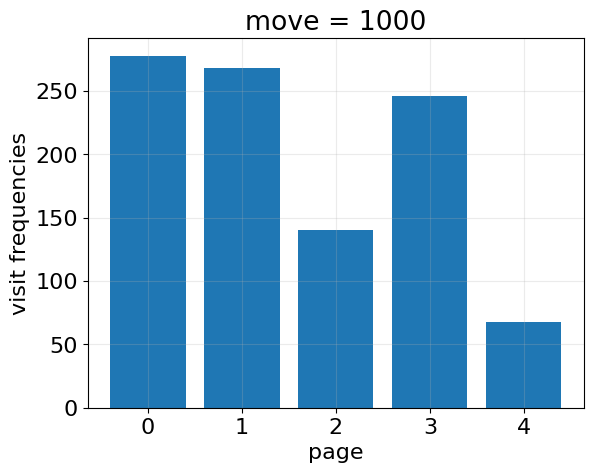

In [21]:
fig, ax = plt.subplots()

ax.bar(range(len(page_rank)), hits)

ax.grid("on")
ax.set_xlabel("page")
ax.set_ylabel("visit frequencies")
ax.set_title(f"move = {selected_move}")
plt.show(fig)

### Mixing a Markov chain

In mathematics, they are a simple way to calculate page rank far more efficiently

First, we can ask the following question:   
What is the probability that the random surfer will move from page `i` to page `j` 
in _two moves_?

Using the power method, we can have a faster convergence with smaller number of moves

In [24]:
def calc_markov(transition_matrix, moves, rng):

  n = len(transition_matrix)

  ranks = [0 for i in range(n)]
  ranks[0] = 1.0      # surfer starts at page 0
  for i in range(moves):
    new_ranks = [0 for i in range(n)]
    for j in range(n):
      for k in range(n):
        new_ranks[j] += ranks[k] * transition_matrix[k][j]
    ranks = new_ranks

  return ranks


In [27]:
for move in [20, 40]:
  print(calc_markov(transition_matrix, move, rng))

[0.2724542506135286, 0.26515356288383163, 0.14668623692407373, 0.24764352262573097, 0.06806242695283575]
[0.2730296312121026, 0.2657275826200819, 0.14618474746661764, 0.24722751126718412, 0.06783052743401512]


The method used in `calc_markov` is far more efficient than simulating the behavior   
of a random sufer, but it is still too slow to actually compute the probabilities    
for a huge matrix corresponding to all the pages on the web.    
That computation is enabled by better data structures for graphs